In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 라이브러리 및 설정 코드

In [2]:
pip install squarify

In [3]:
import json
import re
from collections import Counter
from datetime import datetime
import pandas as pd
import squarify
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [4]:
!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

In [5]:
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정

In [6]:
# NLTK 데이터 다운로드
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# JSON 파일 불러오기 함수
def load_news_data(file_path, source_name):
    with open(file_path, 'r', encoding='utf-8') as file:
        news_content = json.load(file)
    print(f"{source_name} 정치 뉴스기사 수: {len(news_content)}개")
    return news_content

In [8]:
# 뉴스 데이터 로드
fox_news_content = load_news_data('/content/drive/MyDrive/[인공지능기초]/news/fox/fox_news_content.json', 'FOX News')
cbs_news_content = load_news_data('/content/drive/MyDrive/[인공지능기초]/news/cbs/cbs_news_content.json', 'CBS News')

FOX News 정치 뉴스기사 수: 2200개
CBS News 정치 뉴스기사 수: 1140개


In [9]:
# 뉴스 데이터 병합
total_news_contents = fox_news_content + cbs_news_content

## 뉴스에서 각 후보 언급수

뉴스 기사에서 날짜별/주별/월별로 'Trump'와 'Harris'의 언급 수를 집계하여 시각화한다.

In [10]:
def analyze_news_content(news_content, source_name):
    articles_data = []

    for article in news_content:
        date = datetime.strptime(article['date'], '%Y-%m-%d')
        content_lower = article['content'].lower()
        trump_mentions = len(re.findall(r'\btrump\b', content_lower))
        harris_mentions = len(re.findall(r'\bharris\b', content_lower))

        articles_data.append({
            'date': date,
            'trump_mentions': trump_mentions,
            'harris_mentions': harris_mentions
        })

    df = pd.DataFrame(articles_data)

    # 총 언급 수 계산
    print(f"[{source_name}] 전체 트럼프 언급수: {df['trump_mentions'].sum()}")
    print(f"[{source_name}] 전체 해리스 언급수: {df['harris_mentions'].sum()}")

    # 주별, 월별 분석 및 시각화
    for period, period_name in [('D', '일별'), ('W', '주별'), ('M', '월별')]:
        df[period_name] = df['date'].dt.to_period(period).apply(lambda r: r.start_time)
        period_mentions = df.groupby(period_name).agg({
            'trump_mentions': 'sum',
            'harris_mentions': 'sum'
        }).reset_index()

        plt.figure(figsize=(12, 6))
        plt.plot(period_mentions[period_name], period_mentions['trump_mentions'], label='트럼프')
        plt.plot(period_mentions[period_name], period_mentions['harris_mentions'], label='해리스')
        plt.xlabel(f'{period_name} 기간')
        plt.ylabel('언급 횟수')
        plt.title(f'{source_name}의 {period_name} 각 후보자 언급 횟수')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

[FOX News] 전체 트럼프 언급수: 6005
[FOX News] 전체 해리스 언급수: 5404


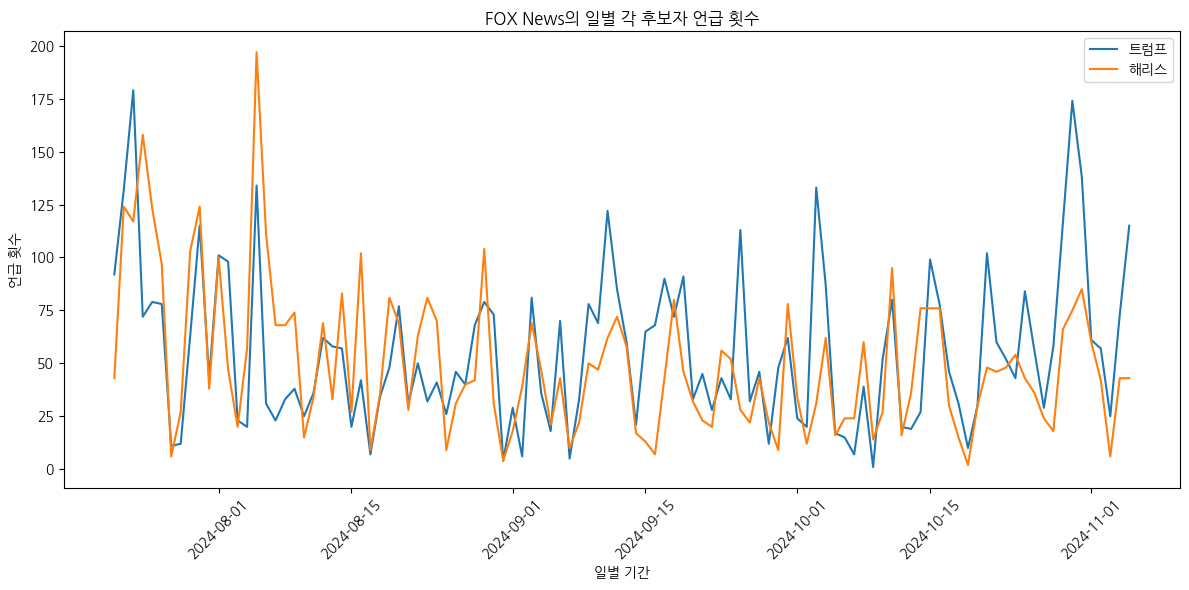

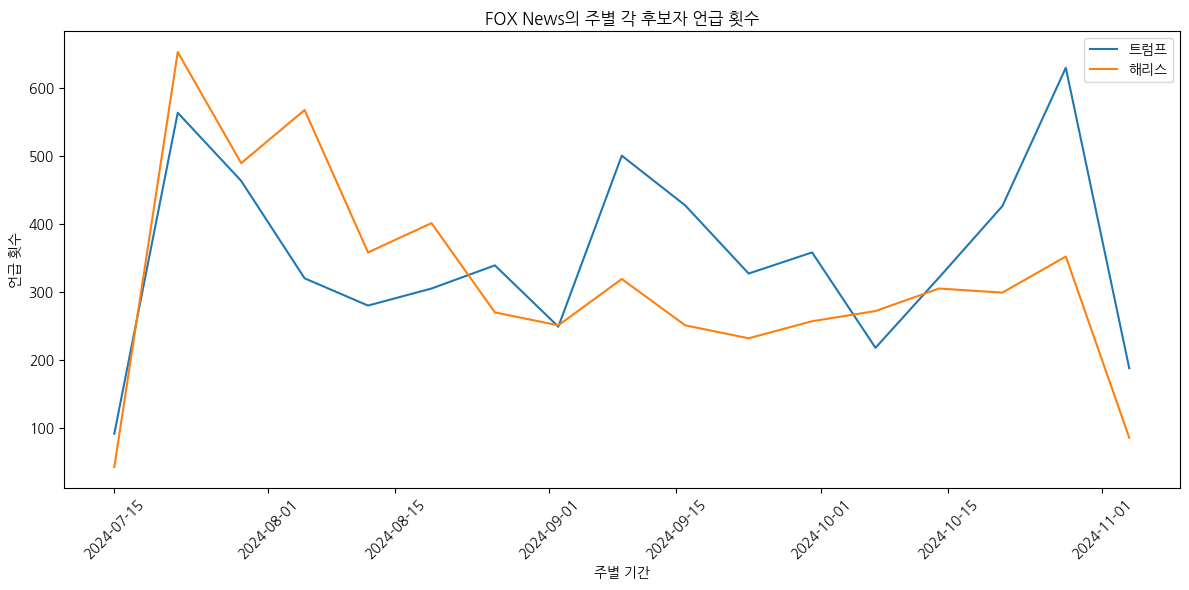

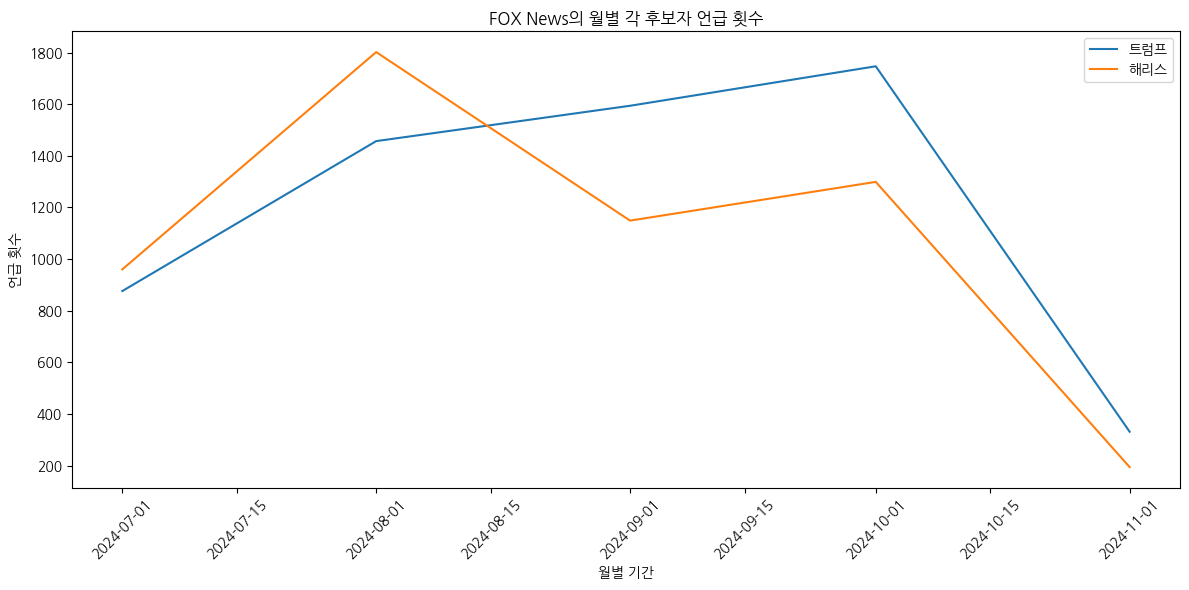

[CBS News] 전체 트럼프 언급수: 6712
[CBS News] 전체 해리스 언급수: 4395


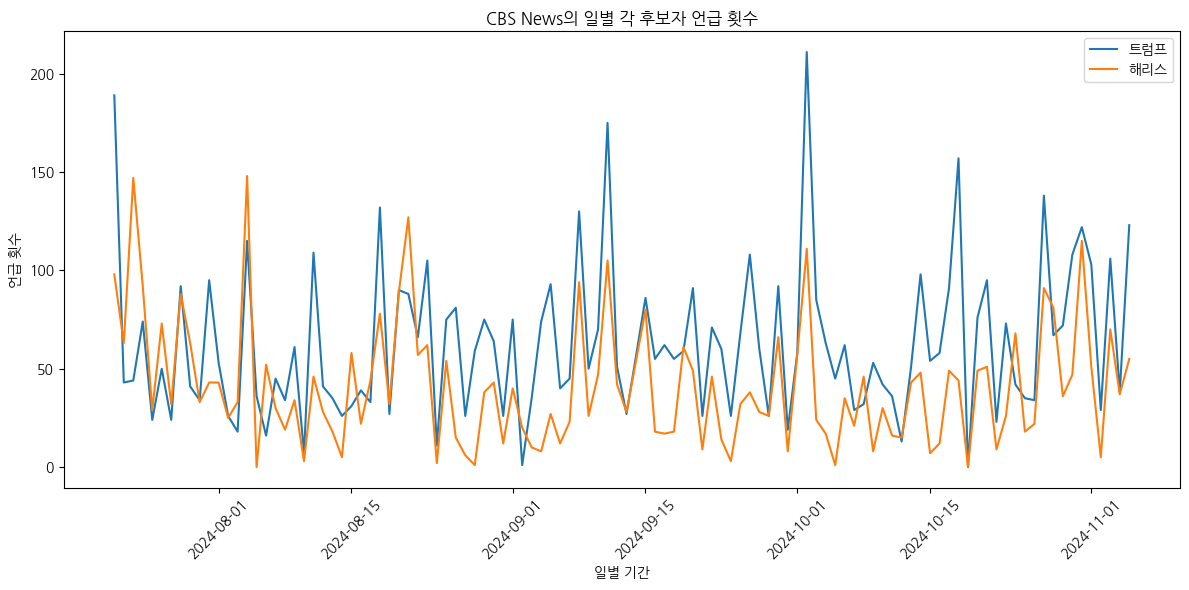

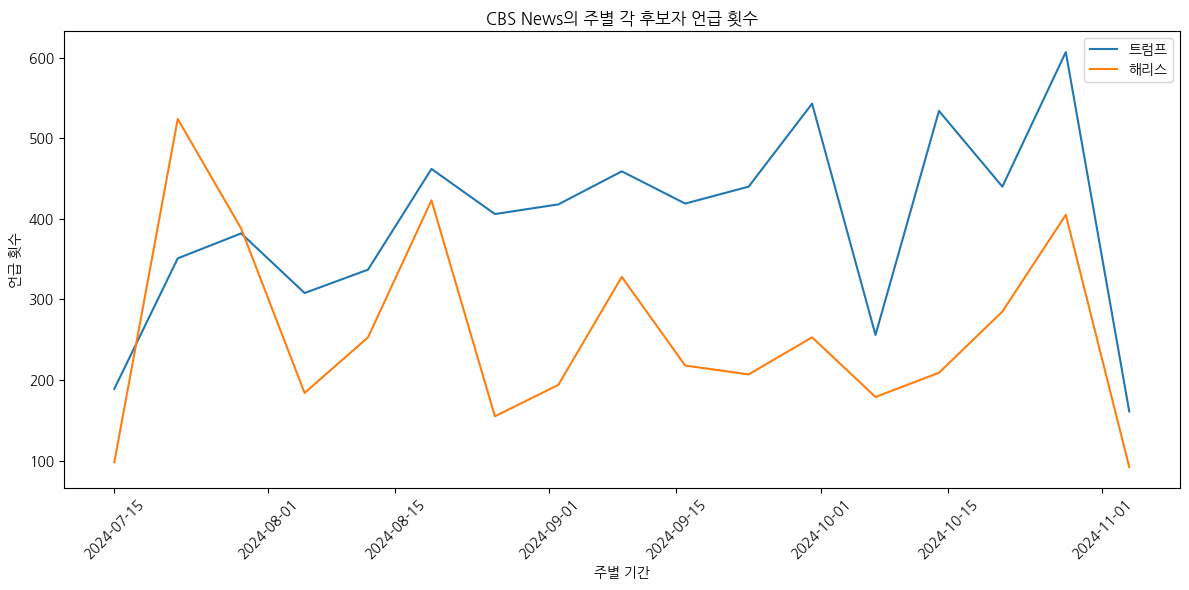

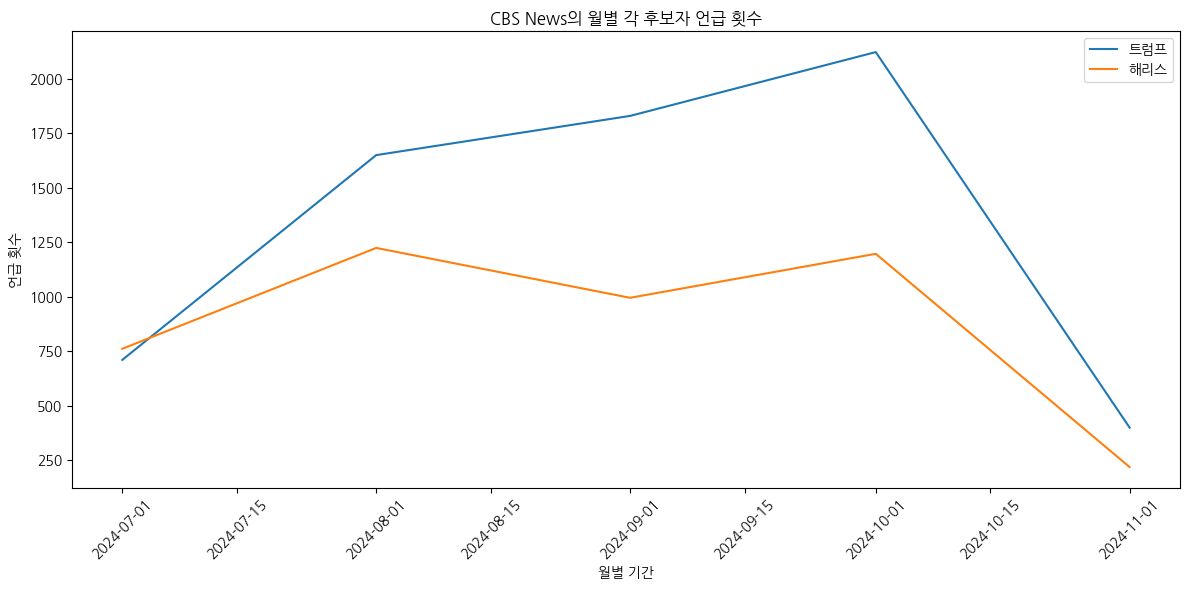

[Total Fox and CBS Mentions] 전체 트럼프 언급수: 12717
[Total Fox and CBS Mentions] 전체 해리스 언급수: 9799


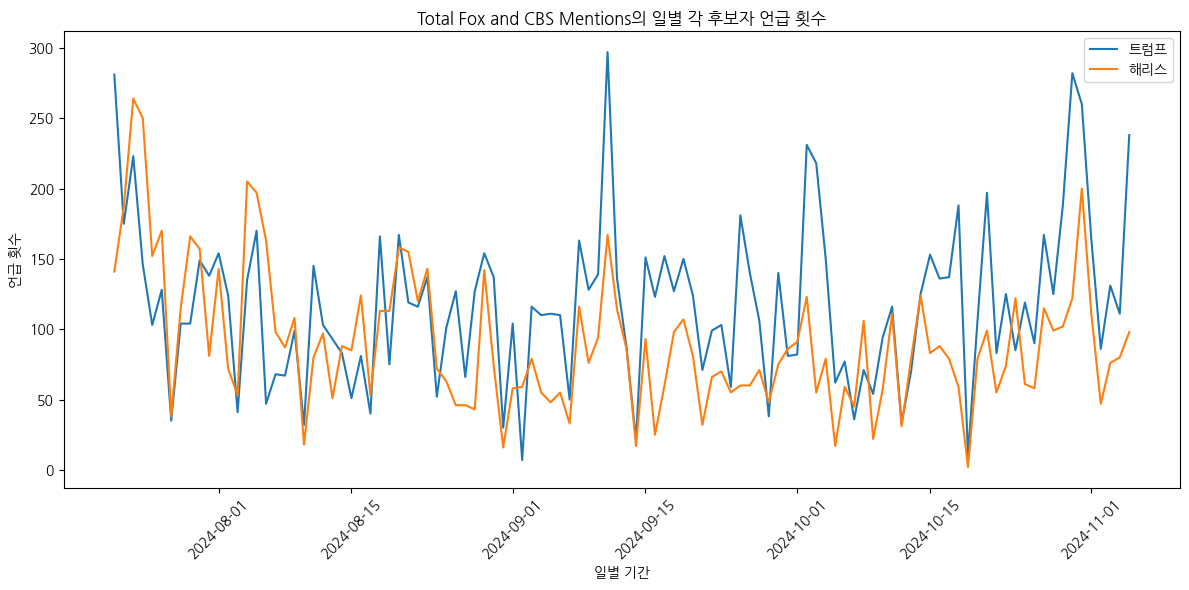

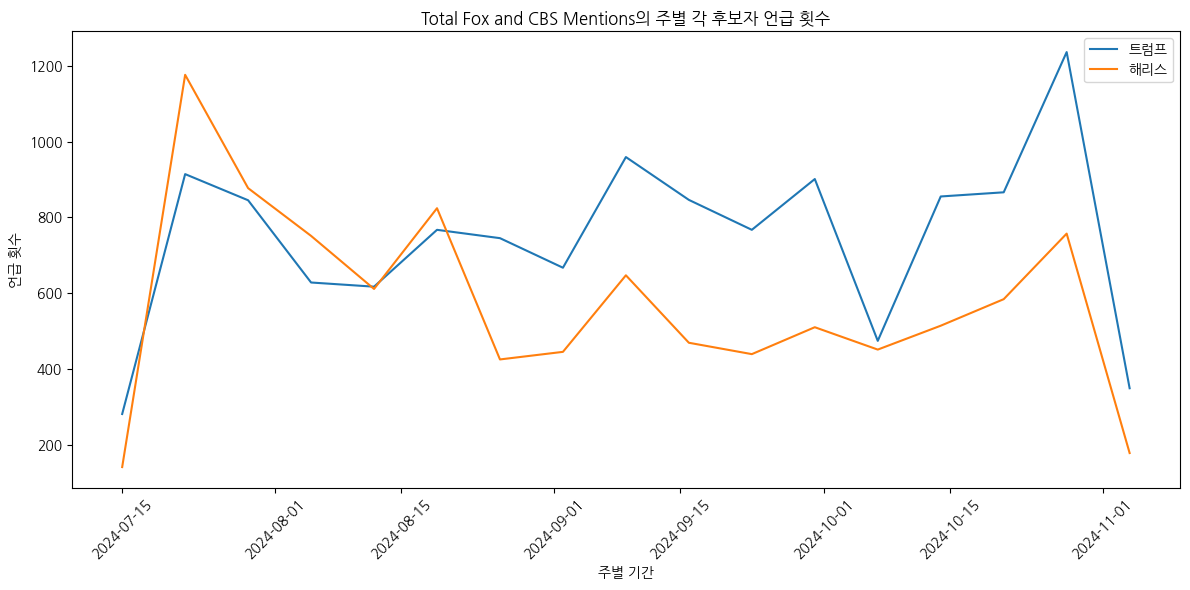

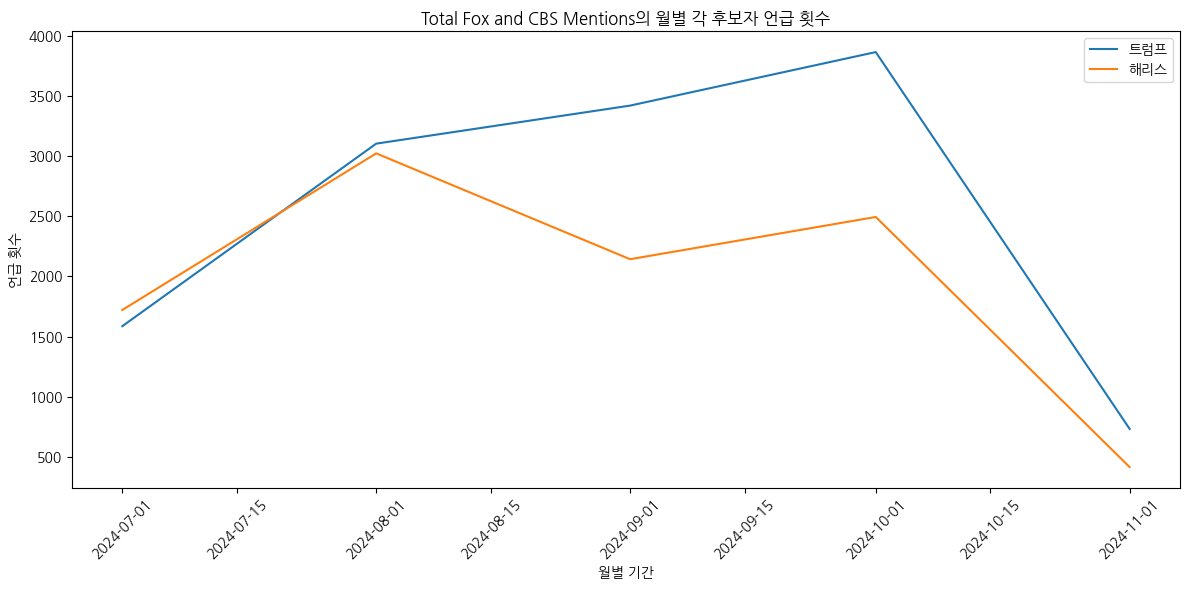

In [11]:
analyze_news_content(fox_news_content, 'FOX News')
analyze_news_content(cbs_news_content, 'CBS News')
analyze_news_content(total_news_contents, 'Total Fox and CBS Mentions')

## 뉴스에서 가장 많이 언급된 상위 단어

뉴스 기사에서 가장 많이 언급된 상위 단어를 분석하고 시각화한다.

In [12]:
def analyze_top_words(news_content, source_name, top_n=20):
    all_text = ' '.join(article['content'].lower() for article in news_content)
    all_text = re.sub(r'[^\w\s]', '', all_text)
    words = word_tokenize(all_text)

    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
    word_counts = Counter(filtered_words)
    top_words = word_counts.most_common(top_n)

    df_top_words = pd.DataFrame(top_words, columns=['word', 'frequency'])
    df_top_words['rank'] = df_top_words['frequency'].rank(method='dense', ascending=False).astype(int)

    print(f"\n[{source_name}]에서 상위 {top_n}개 단어:")
    print(df_top_words)

    # 시각화
    plt.figure(figsize=(12, 6))
    squarify.plot(sizes=df_top_words['frequency'], label=df_top_words['word'] + '\n' + df_top_words['frequency'].astype(str), alpha=.8)
    plt.title(f'Top {top_n} Words in {source_name}')
    plt.axis('off')
    plt.show()

    return df_top_words


[FOX News]에서 상위 20개 단어:
         word  frequency  rank
0        news       8894     1
1         fox       8579     2
2   president       6451     3
3        said       6405     4
4       trump       5177     5
5      harris       4733     6
6          us       4318     7
7       biden       3876     8
8       house       3718     9
9     digital       3386    10
10     former       3104    11
11      would       2631    12
12        get       2484    13
13      state       2477    14
14       also       2396    15
15      video       2309    16
16        new       2308    17
17     images       2290    18
18     border       2189    19
19   campaign       2177    20


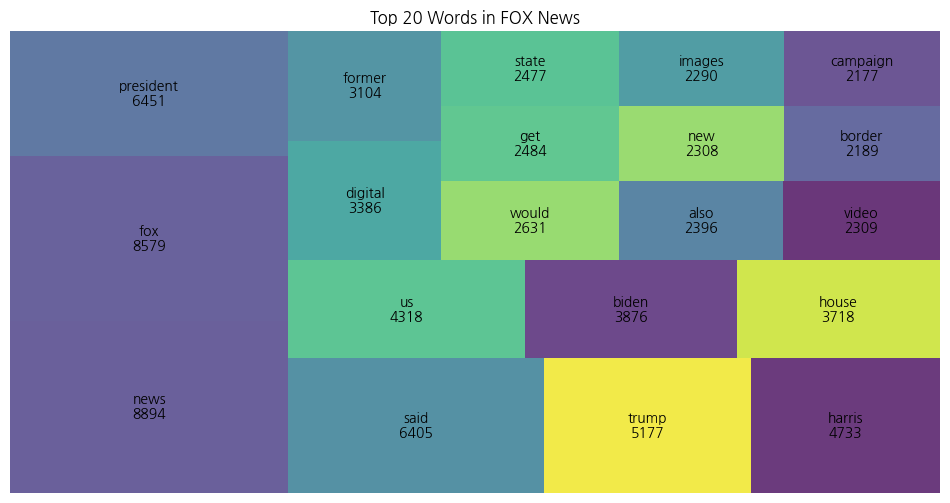


[CBS News]에서 상위 20개 단어:
         word  frequency  rank
0        said       7151     1
1       trump       5435     2
2   president       4998     3
3      harris       4115     4
4          us       3429     5
5       would       2680     6
6    election       2623     7
7      people       2565     8
8        news       2503     9
9    margaret       2371    10
10       also       2272    11
11      state       2239    12
12        cbs       2217    13
13   campaign       2184    14
14      biden       2153    15
15     former       2118    16
16       know       2090    17
17    brennan       2057    18
18      think       2038    19
19        one       2033    20


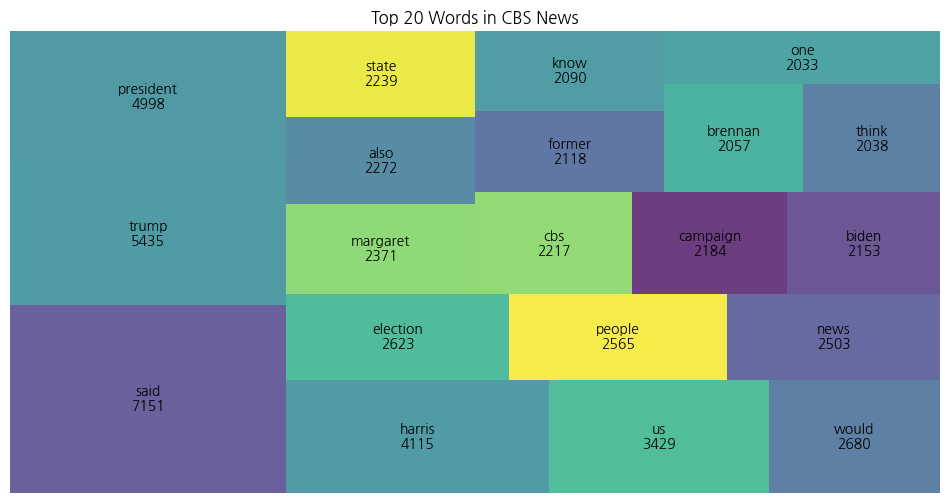

In [13]:
df_fox_top_words = analyze_top_words(fox_news_content, 'FOX News')
df_cbs_top_words = analyze_top_words(cbs_news_content, 'CBS News')

In [14]:
# 이후 분석을 위해 날짜, 내용, 인물 언급 여부 df로 처리하는 함수
def process_news_content(news_content, source_name):
    articles_data = []

    for article in news_content:
        # 날짜를 추출하여 날짜/시간 객체로 변환
        date_str = article['date']
        date = datetime.strptime(date_str, '%Y-%m-%d')

        content = article['content']

        # 소문자로 변환
        content_lower = content.lower()

        # 'trump' 또는 'harris'가 언급되었는지 확인
        trump_mentioned = 'trump' in content_lower
        harris_mentioned = 'harris' in content_lower

        articles_data.append({
            'date': date,
            'content': content,
            'trump_mentioned': trump_mentioned,
            'harris_mentioned': harris_mentioned
        })

    df = pd.DataFrame(articles_data)

    return df

## 뉴스 주별 기사량 비교

주간 기준으로 FOX와 CBS 뉴스 기사의 개수를 시각화한다.

In [15]:
def visualize_articles_per_week_combined(df_fox, df_cbs):
    df_fox['week'] = df_fox['date'].dt.to_period('W').apply(lambda r: r.start_time)
    df_cbs['week'] = df_cbs['date'].dt.to_period('W').apply(lambda r: r.start_time)

    articles_per_week_fox = df_fox.groupby('week').size().reset_index(name='article_count')
    articles_per_week_cbs = df_cbs.groupby('week').size().reset_index(name='article_count')

    merged_articles = pd.merge(articles_per_week_fox, articles_per_week_cbs, on='week', how='outer', suffixes=('_fox', '_cbs')).fillna(0)
    merged_articles = merged_articles.sort_values('week')

    plt.figure(figsize=(14, 7))
    plt.plot(merged_articles['week'], merged_articles['article_count_fox'], label='FOX News', color='blue', marker='o')
    plt.plot(merged_articles['week'], merged_articles['article_count_cbs'], label='CBS News', color='red', marker='o')
    plt.xlabel('Week')
    plt.ylabel('기사 수')
    plt.title('주간 기사 수: FOX vs CBS')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

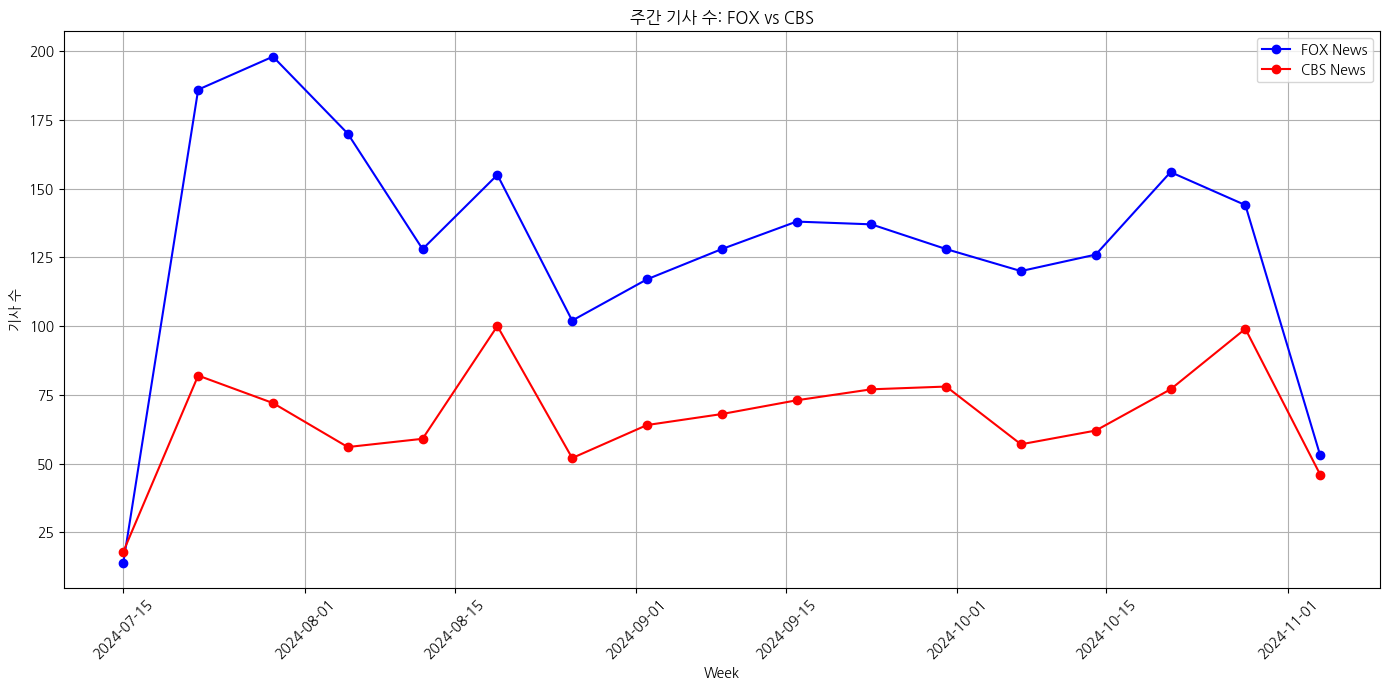

In [16]:
df_fox = process_news_content(fox_news_content, 'FOX News')
df_cbs = process_news_content(cbs_news_content, 'CBS News')
visualize_articles_per_week_combined(df_fox, df_cbs)

## 후보자 관련 단어 빈도수

특정 후보자와 관련된 기사의 상위 단어를 막대 그래프로 시각화한다.

In [17]:
# 5. 후보자 관련 단어 빈도 막대그래프 생성 함수
def generate_bargraph(df, candidate_name, source_name, top_n=20):
    """
    특정 후보자와 관련된 기사의 상위 단어를 막대 그래프로 시각화합니다.
    """
    candidate_lower = candidate_name.lower()

    # 후보자가 언급된 기사만 필터링
    candidate_articles = df[df[f'{candidate_lower}_mentioned']]

    # 모든 기사 내용을 하나의 텍스트로 결합
    all_text = ' '.join(candidate_articles['content'].tolist())

    # 소문자로 변환
    all_text = all_text.lower()

    # 구두점 제거
    all_text = re.sub(r'[^\w\s]', '', all_text)

    # 단어 토큰화
    words = word_tokenize(all_text)

    # 불용어 및 후보자 이름 제거
    stop_words = set(stopwords.words('english'))
    stop_words.update([candidate_lower])  # 후보자 이름도 불용어에 추가
    filtered_words = [word for word in words if word not in stop_words and word.isalpha()]

    # 단어 빈도 계산
    word_counts = Counter(filtered_words)

    # 상위 N개 단어 추출
    top_words = word_counts.most_common(top_n)
    df_top_words = pd.DataFrame(top_words, columns=['word', 'frequency'])

    # 막대 그래프 생성
    plt.figure(figsize=(15, 8))
    plt.barh(df_top_words['word'][::-1], df_top_words['frequency'][::-1], color='skyblue')
    plt.xlabel('빈도수')
    plt.ylabel('단어')
    plt.title(f'{source_name}에서 {candidate_name} 관련 상위 {top_n} 단어', fontsize=16)
    plt.tight_layout()
    plt.show()


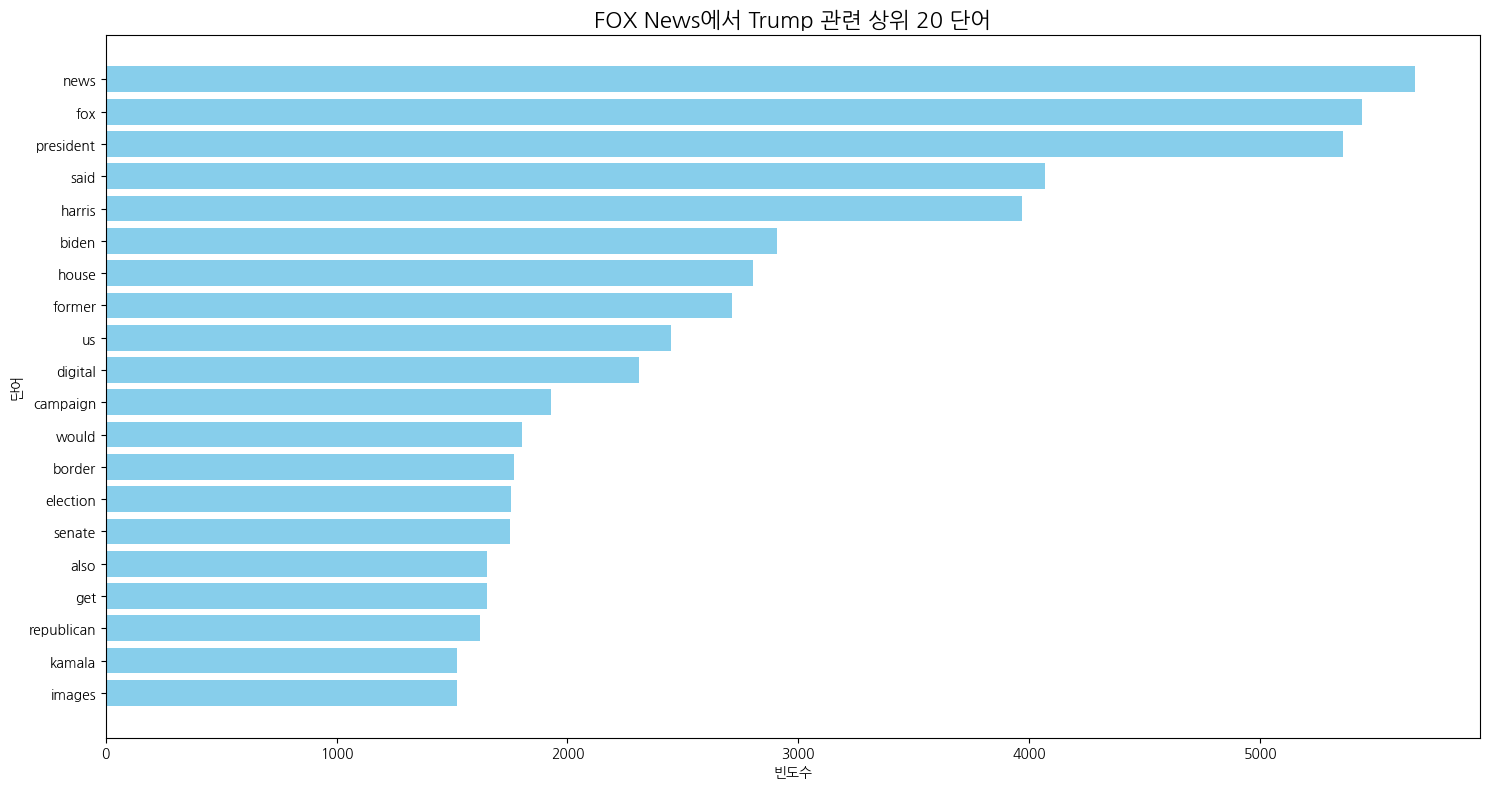

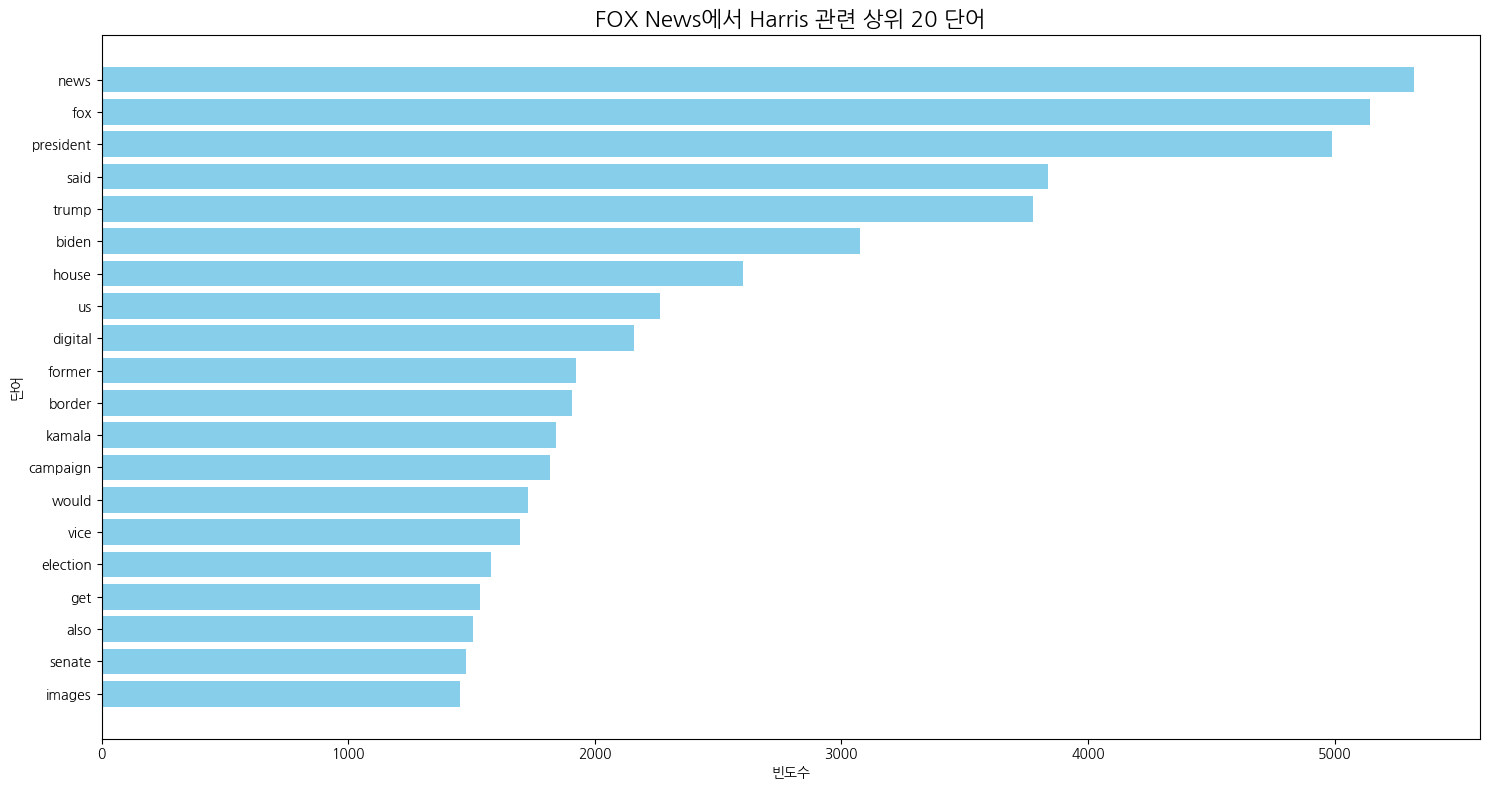

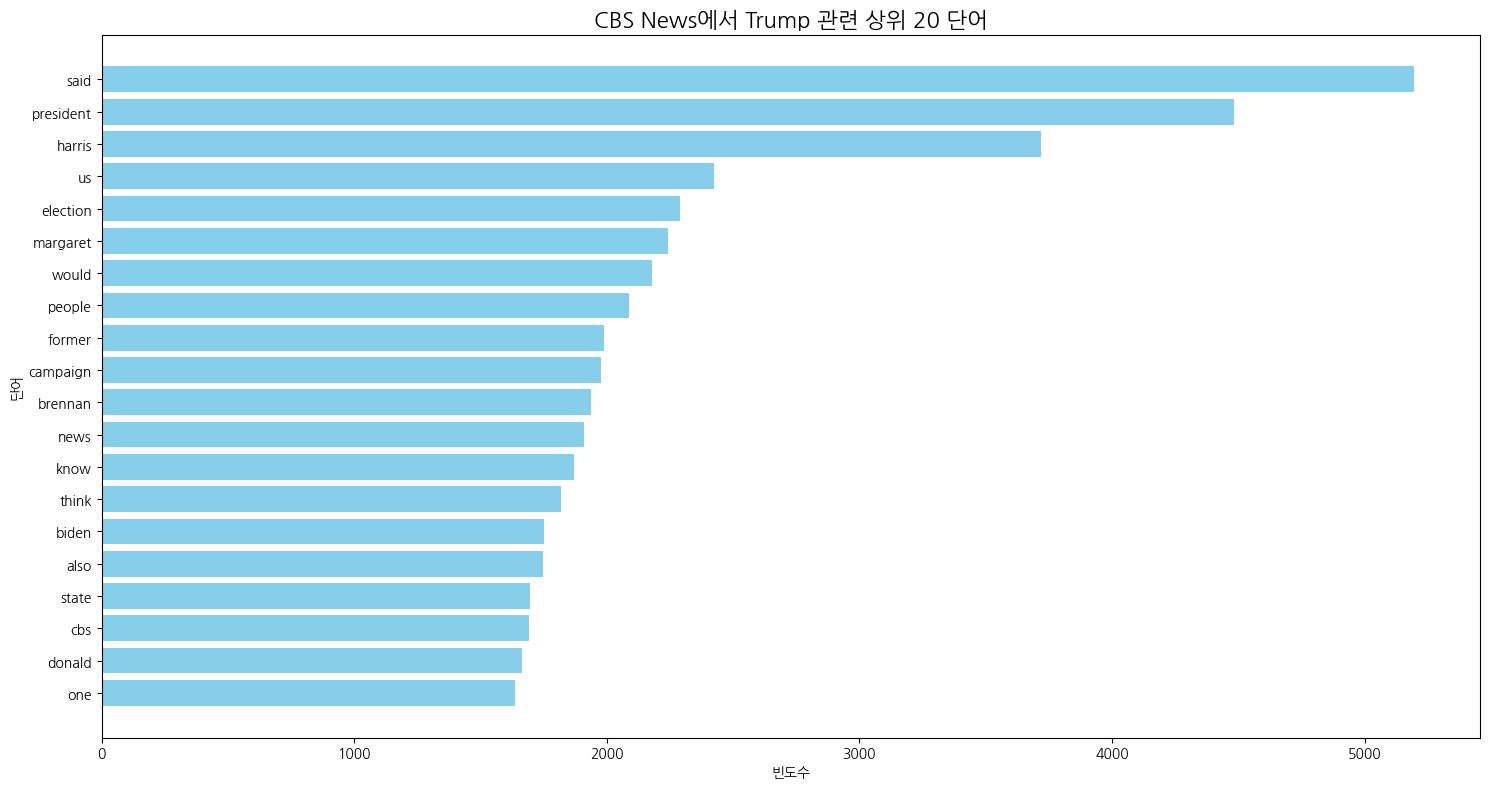

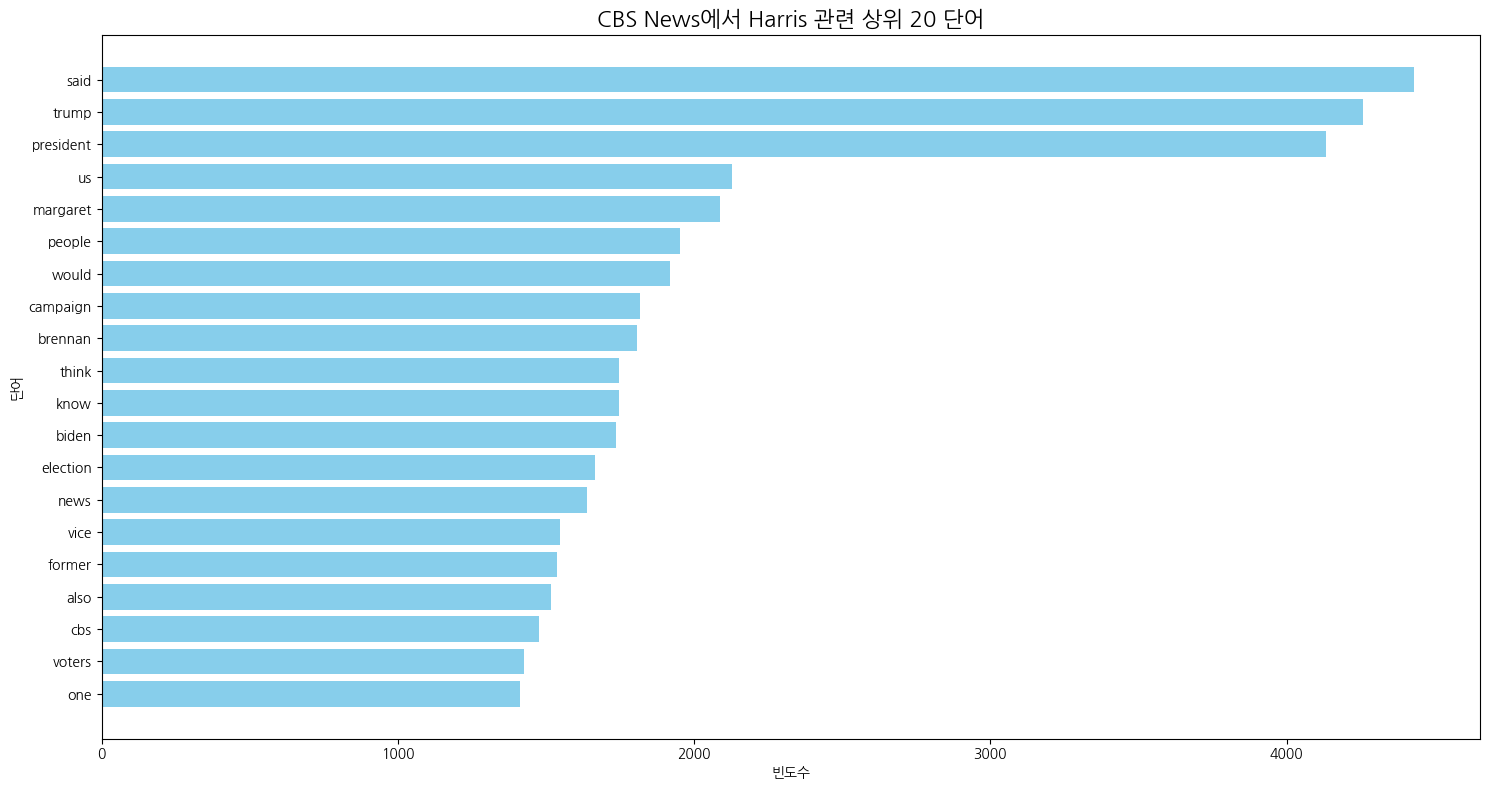

In [18]:
generate_bargraph(df_fox, 'Trump', 'FOX News', top_n=20)
generate_bargraph(df_fox, 'Harris', 'FOX News', top_n=20)
generate_bargraph(df_cbs, 'Trump', 'CBS News', top_n=20)
generate_bargraph(df_cbs, 'Harris', 'CBS News', top_n=20)

특정 후보자와 관련된 기사의 상위 단어를 워드클라우드로 표현한다.

In [25]:
def generate_wordcloud(df, candidate_name, source_name):
    candidate_lower = candidate_name.lower()

    # 후보자가 언급된 기사만 필터링
    candidate_articles = df[df[f'{candidate_lower}_mentioned']]

    # 모든 기사 내용을 하나의 텍스트로 결합
    all_text = ' '.join(candidate_articles['content'].tolist())

    # 소문자로 변환
    all_text = all_text.lower()

    # 구두점 제거
    all_text = re.sub(r'[^\w\s]', '', all_text)

    # 단어 토큰화
    words = word_tokenize(all_text)

    # 불용어 및 후보자 이름 제거
    stop_words = set(stopwords.words('english'))
    stop_words.update([candidate_lower])  # 후보자 이름도 불용어에 추가
    filtered_words = [word for word in words if word not in stop_words and word.isalpha()]

    # 단어 빈도 계산
    word_counts = Counter(filtered_words)

    # 마스크 이미지 설정 및 전처리
    mask_img_path = f"/content/drive/MyDrive/[인공지능기초]/analysis/news/{candidate_lower}_mask_img.png"
    img = Image.open(mask_img_path).convert("L")  # 그레이스케일로 변환
    enhancer = ImageEnhance.Brightness(img)
    img_enhanced = enhancer.enhance(1.5)
    mask = ImageOps.invert(img_enhanced)  # 불투명한 부분을 검은색으로, 투명한 부분을 흰색으로 변환
    mask = np.array(mask)  # 배열로 변환

    # 후보자에 따라 테두리 색상 설정
    contour_color = 'red' if candidate_name.lower() == 'trump' else 'blue'

    # wordcloud 생성
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        mask=mask,
        contour_width=0.7,
        contour_color=contour_color
    ).generate_from_frequencies(word_counts)

    # wordcloud 시각화
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{source_name}에서 {candidate_name} 관련 단어', fontsize=20)
    plt.show()


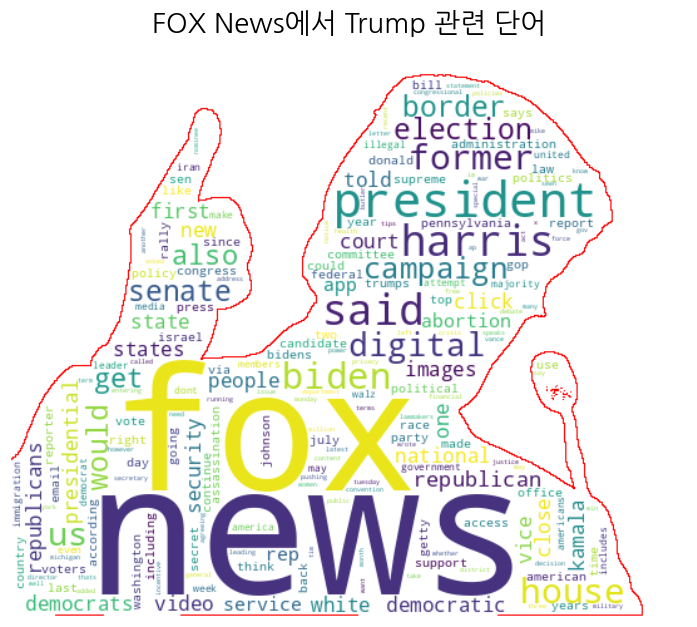

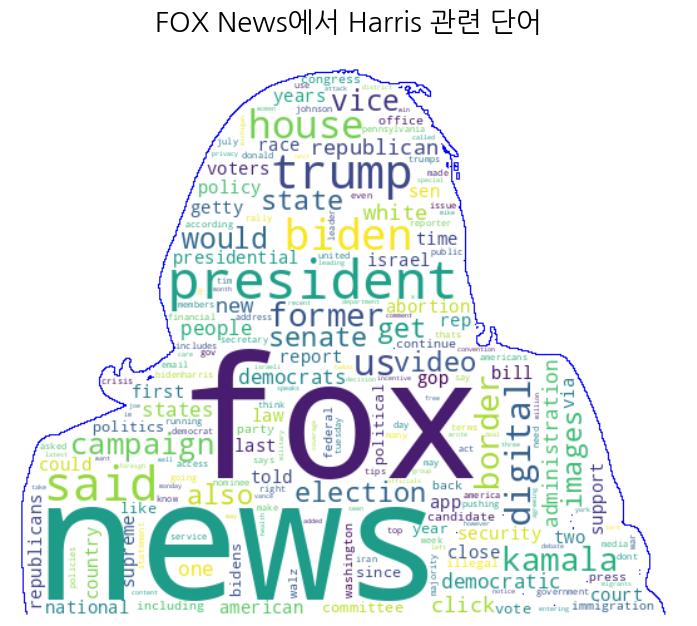

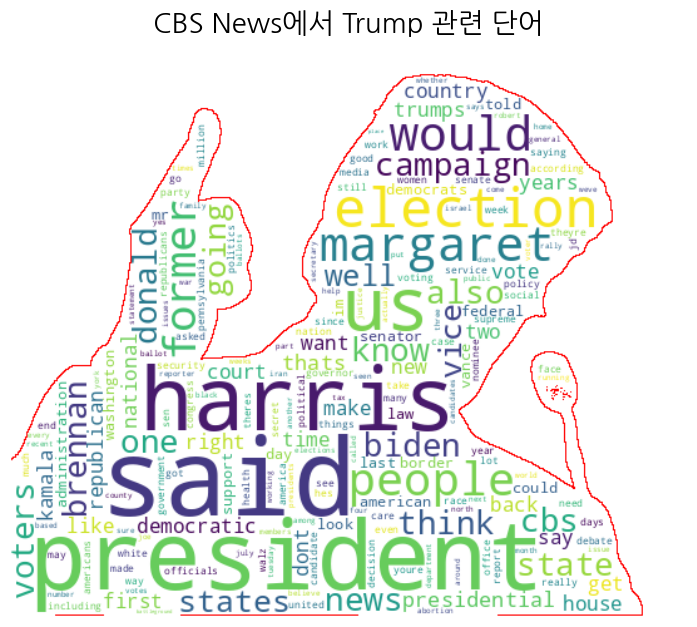

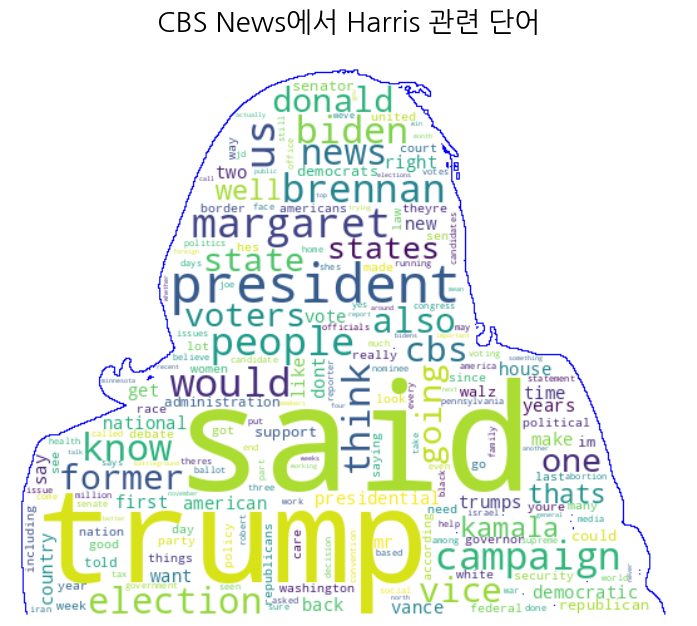

In [26]:
generate_wordcloud(df_fox, 'Trump', 'FOX News')
generate_wordcloud(df_fox, 'Harris', 'FOX News')
generate_wordcloud(df_cbs, 'Trump', 'CBS News')
generate_wordcloud(df_cbs, 'Harris', 'CBS News')

**fox, news, said** 같은 단어가 많이 나온다. tf-idf를 진행하여 중요한 단어를 워드클라우드로 표현하면 좋을것 같다.